### Notebook for the cell proportion analysis of Mixed cell states in Healthy_vs_COPD CTRL_vs_IAV data

- **Developed by**: Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 231204
- **Last modified**: 231204

### Load required packages

In [1]:
import milopy
import numpy as np
import pandas as pd
import scanpy as sc
import milopy.core as milo
import matplotlib.pyplot as plt

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                 10.1.0
appnope             0.1.3
asttokens           NA
cffi                1.16.0
comm                0.2.0
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.0
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
get_annotations     NA
h5py                3.10.0
importlib_resources NA
ipykernel           6.27.1
ipywidgets          8.1.1
jedi                0.19.1
jinja2              3.1.2
joblib              1.3.2
kiwisolver          1.4.5
llvmlite            0.41.1
markupsafe          2.1.3
matplotlib          3.8.2
milopy              0.1.1
mpl_toolkits        NA
natsort             8.4.0
numba               0.58.1
numpy               1.26.2
packaging           23.2
pandas              2.1.3
parso               0.8.3
patsy               0.5.4
pexpect             4.9.0
platformdirs        4.0.0
prompt_toolkit      3.0.41
psutil              5

### Load working object

In [3]:
adata_all = sc.read_h5ad('../../../data/Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad')
adata_all

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

### Subset population of interest

In [4]:
adata_all.obs['cell_type'].cat.categories

Index(['ciliated', 'club', 'basal', 'goblet', 'mixed'], dtype='object')

In [5]:
adata = adata_all[adata_all.obs['cell_type'].isin(['goblet'])]
adata

View of AnnData object with n_obs × n_vars = 22192 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [6]:
adata.obs['batch'].cat.categories

Index(['CHE01_CTRL', 'CHE01_IAV', 'CHE02_CTRL', 'CHE02_IAV', 'CHE03_CTRL',
       'CHE03_IAV', 'CSE03_CTRL', 'CSE03_IAV', 'CSE_06_CRTL', 'CSE_06_IAV',
       'GER02_CTRL', 'GER02_IAV', 'GER12_CTRL', 'GER12_IAV', 'GER14_CRTL',
       'GER14_IAV', 'GnR08_CTRL', 'GnR08_IAV', 'GnR_07_CTRL', 'GnR_07_IAV',
       'ST07_CSE_CTRL', 'ST08_GnR_CTRL', 'ST09_CSE_IAV', 'ST10_GnR_IAV'],
      dtype='object')

### Build k-NN graph

In [7]:
sc.pp.neighbors(adata, n_neighbors = 50, random_state = 1712, use_rep = 'X_scANVI')

computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)


### Construct neighbourhoods a lá `milo`

In [8]:
milo.make_nhoods(adata)
adata.obsm["nhoods"]

/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/milopy/core.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.80330265 1.81965792 2.36141348 ... 1.78461862 2.3483851  2.33744216]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"]


<22192x1652 sparse matrix of type '<class 'numpy.float32'>'
	with 185325 stored elements in Compressed Sparse Row format>

In [9]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
476315-ST07_CSE_CTRL-V1,1,1.803303
509775-ST07_CSE_CTRL-V1,1,1.819658
48171-ST07_CSE_CTRL-V1,1,2.361413
334727-ST07_CSE_CTRL-V1,1,1.761356
281585-ST07_CSE_CTRL-V1,1,1.990839
...,...,...
8722627-CSE03_IAV-V6,1,2.170038
3565104-CSE03_IAV-V6,1,2.717051
9740235-CSE03_IAV-V6,1,1.784619
10649539-CSE03_IAV-V6,1,2.348385


(array([ 4.,  3.,  6.,  7.,  8., 19., 16., 12., 19., 25., 31., 45., 39.,
        45., 35., 39., 27., 50., 45., 40., 53., 50., 44., 37., 49., 44.,
        51., 42., 38., 41., 28., 37., 43., 14., 44., 35., 35., 33., 20.,
        21., 33., 25., 19., 12., 17., 21., 20., 14., 22.,  3., 17., 15.,
         9., 10.,  7., 15.,  6.,  7., 12., 10.,  8.,  2.,  5.,  9.,  4.,
         7.,  1.,  1.,  7.,  6.,  2.,  4.,  1.,  5.,  3.,  4.,  1.,  1.,
         1.,  1.,  2.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.]),
 array([ 55.        ,  56.93999863,  58.88000107,  60.81999969,
         62.75999832,  64.69999695,  66.63999939,  68.58000183,
         70.51999664,  72.45999908,  74.40000153,  76.33999634,
         78.27999878,  80.22000122,  82.16000366,  84.09999847,
         86.04000092,  87.98000336,  89.91999817,  91.86000061,
         93.80000305,  95.73999786,  97.68000031,  99.62000275,
        101.55999756, 103.5       , 105.44000244, 

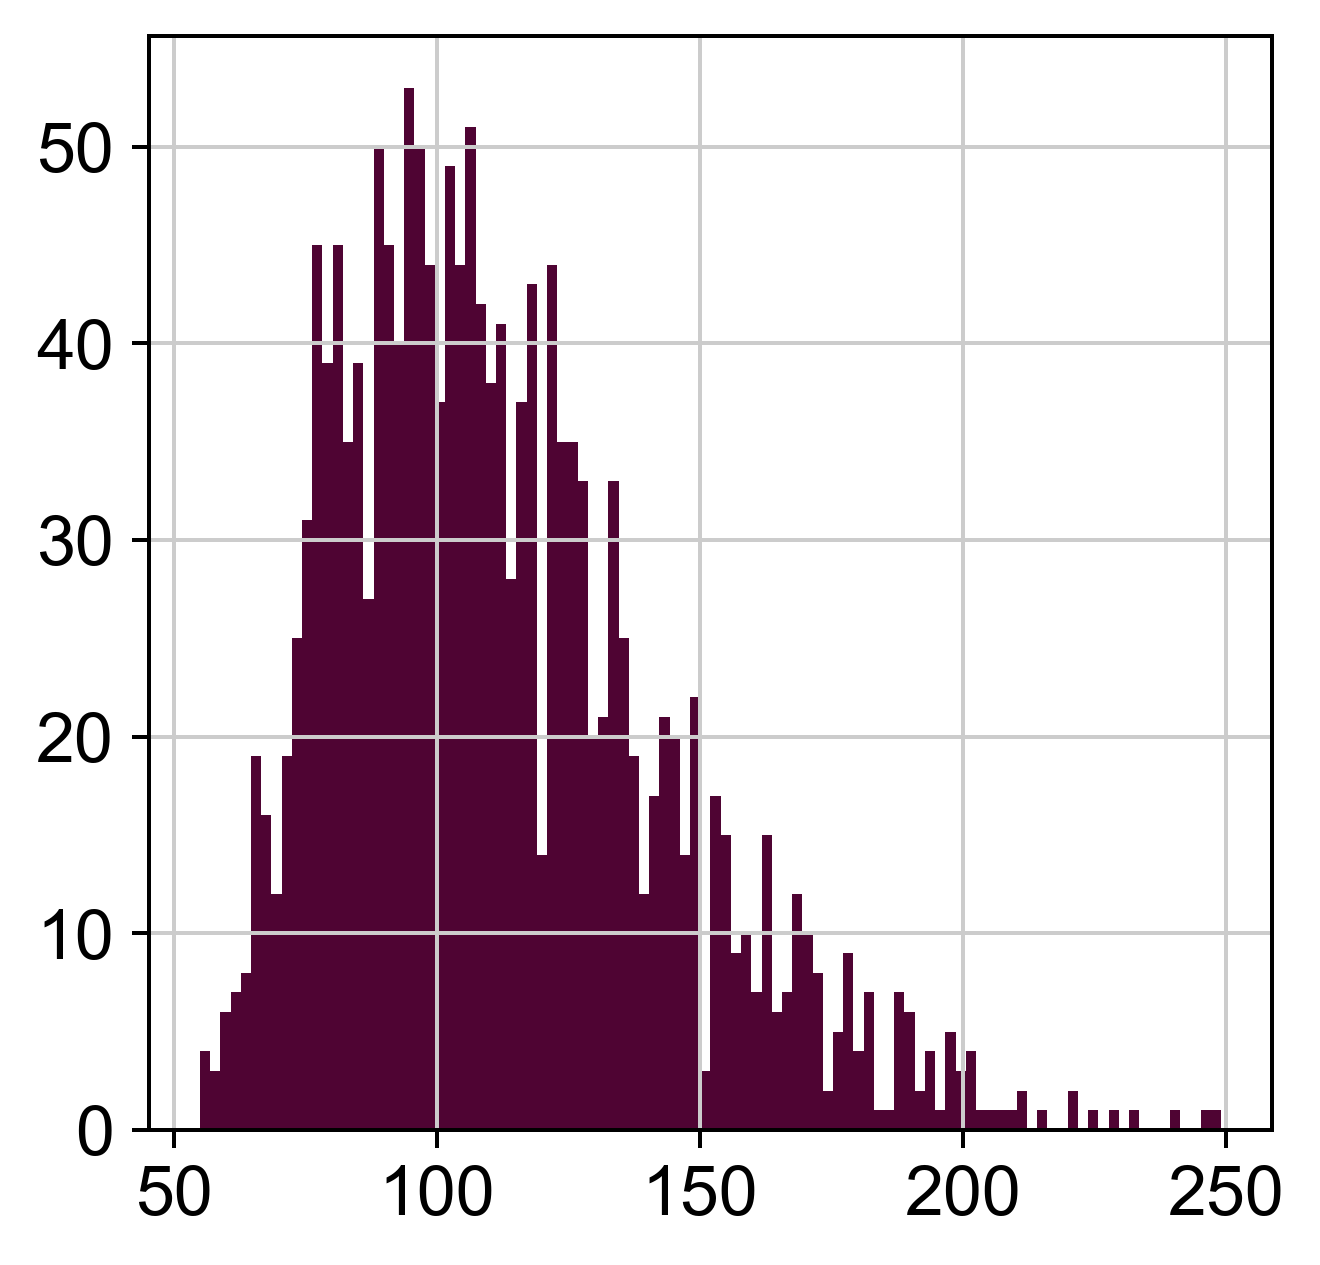

In [10]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins = 100, color = '#4F0433')

### Count cells in neighbourhoods

In [11]:
milo.count_nhoods(adata, sample_col = "batch")
adata.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 1652 × 24
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

### Differential abundance testing with GLM

In [12]:
milo.DA_nhoods(adata, design = "~ group")
adata.uns["nhood_adata"].obs

/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/milopy/core.py:239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/milopy/core.py:311: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/milopy/core.py:312: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,476315-ST07_CSE_CTRL-V1,1.803303,-2.259465,10.295200,2.888774,0.090014,0.223406,0.230794
1,509775-ST07_CSE_CTRL-V1,1.819658,-1.903497,9.817000,2.323730,0.128242,0.273011,0.279833
2,48171-ST07_CSE_CTRL-V1,2.361413,-1.452446,9.555740,1.299282,0.255069,0.405444,0.411370
3,334727-ST07_CSE_CTRL-V1,1.761356,-2.367581,10.080666,3.288261,0.070562,0.191696,0.198879
4,281585-ST07_CSE_CTRL-V1,1.990839,-2.289346,9.777194,3.202228,0.074331,0.197419,0.204432
...,...,...,...,...,...,...,...,...
1647,8722627-CSE03_IAV-V6,2.170038,6.061994,10.356574,14.597168,0.000155,0.006390,0.008197
1648,3565104-CSE03_IAV-V6,2.717051,2.335109,9.785044,3.487803,0.062589,0.180448,0.188314
1649,9740235-CSE03_IAV-V6,1.784619,-3.270071,9.868776,5.861811,0.015938,0.086047,0.093633
1650,10649539-CSE03_IAV-V6,2.348385,2.029253,9.684770,2.639405,0.105068,0.242558,0.249198


- Evaluate results

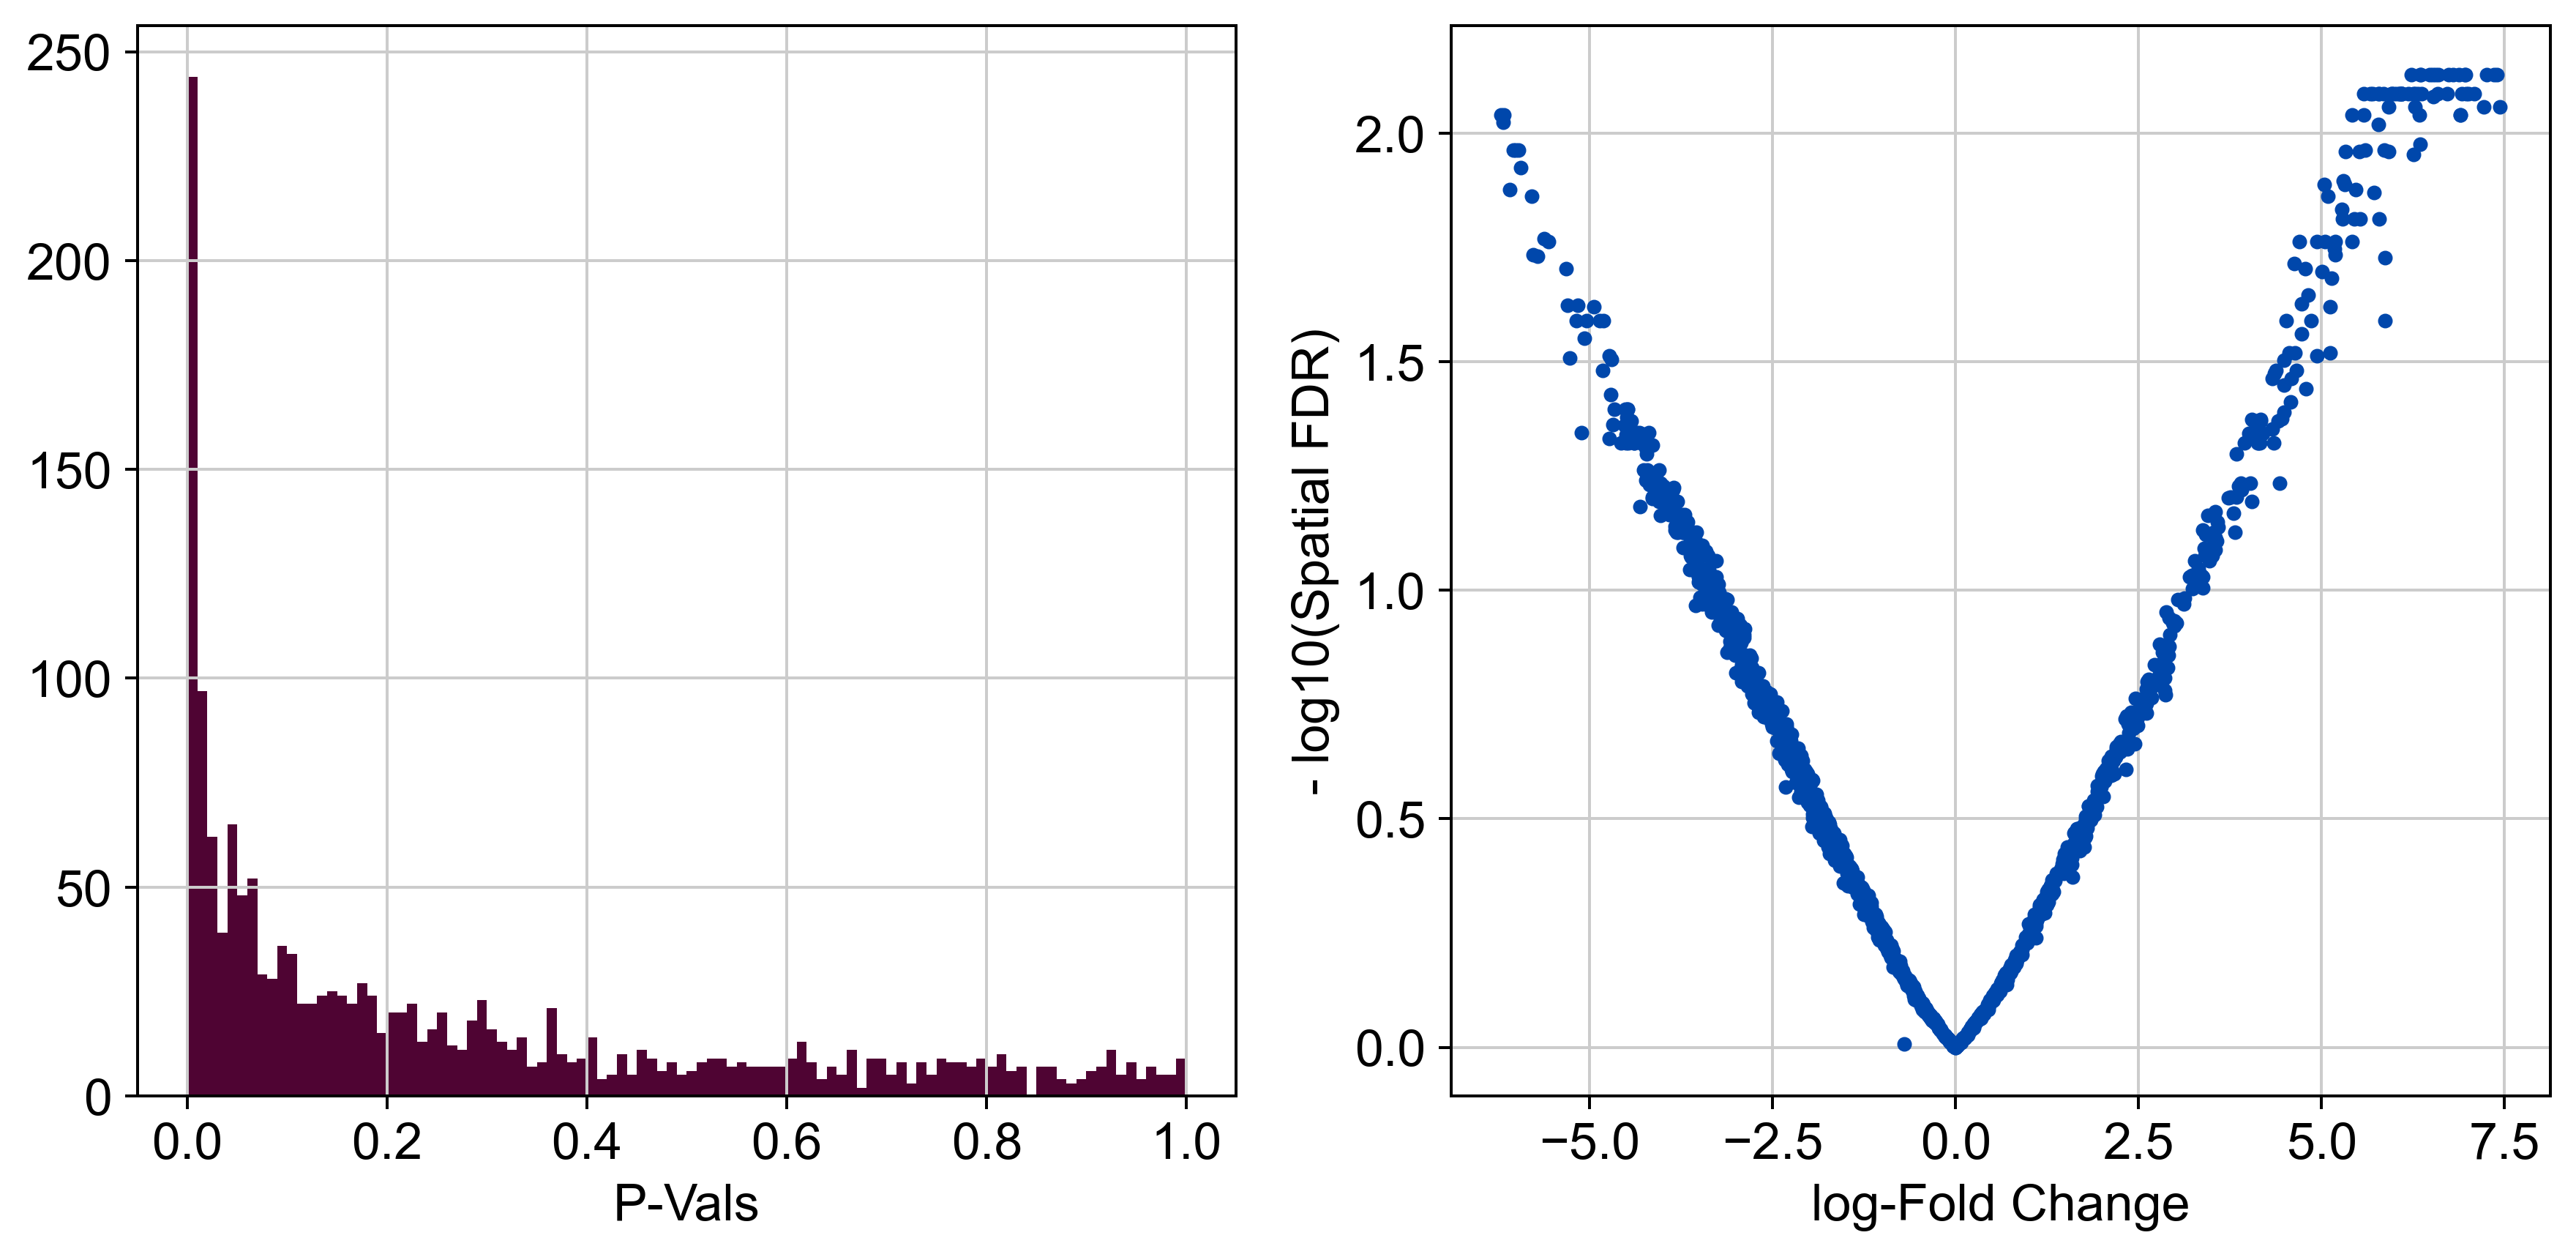

In [13]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins = 100, color = '#4F0433')
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.', color = '#0047AB')
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [14]:
milo_results = adata.uns["nhood_adata"].obs
milo_results

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,476315-ST07_CSE_CTRL-V1,1.803303,-2.259465,10.295200,2.888774,0.090014,0.223406,0.230794
1,509775-ST07_CSE_CTRL-V1,1.819658,-1.903497,9.817000,2.323730,0.128242,0.273011,0.279833
2,48171-ST07_CSE_CTRL-V1,2.361413,-1.452446,9.555740,1.299282,0.255069,0.405444,0.411370
3,334727-ST07_CSE_CTRL-V1,1.761356,-2.367581,10.080666,3.288261,0.070562,0.191696,0.198879
4,281585-ST07_CSE_CTRL-V1,1.990839,-2.289346,9.777194,3.202228,0.074331,0.197419,0.204432
...,...,...,...,...,...,...,...,...
1647,8722627-CSE03_IAV-V6,2.170038,6.061994,10.356574,14.597168,0.000155,0.006390,0.008197
1648,3565104-CSE03_IAV-V6,2.717051,2.335109,9.785044,3.487803,0.062589,0.180448,0.188314
1649,9740235-CSE03_IAV-V6,1.784619,-3.270071,9.868776,5.861811,0.015938,0.086047,0.093633
1650,10649539-CSE03_IAV-V6,2.348385,2.029253,9.684770,2.639405,0.105068,0.242558,0.249198


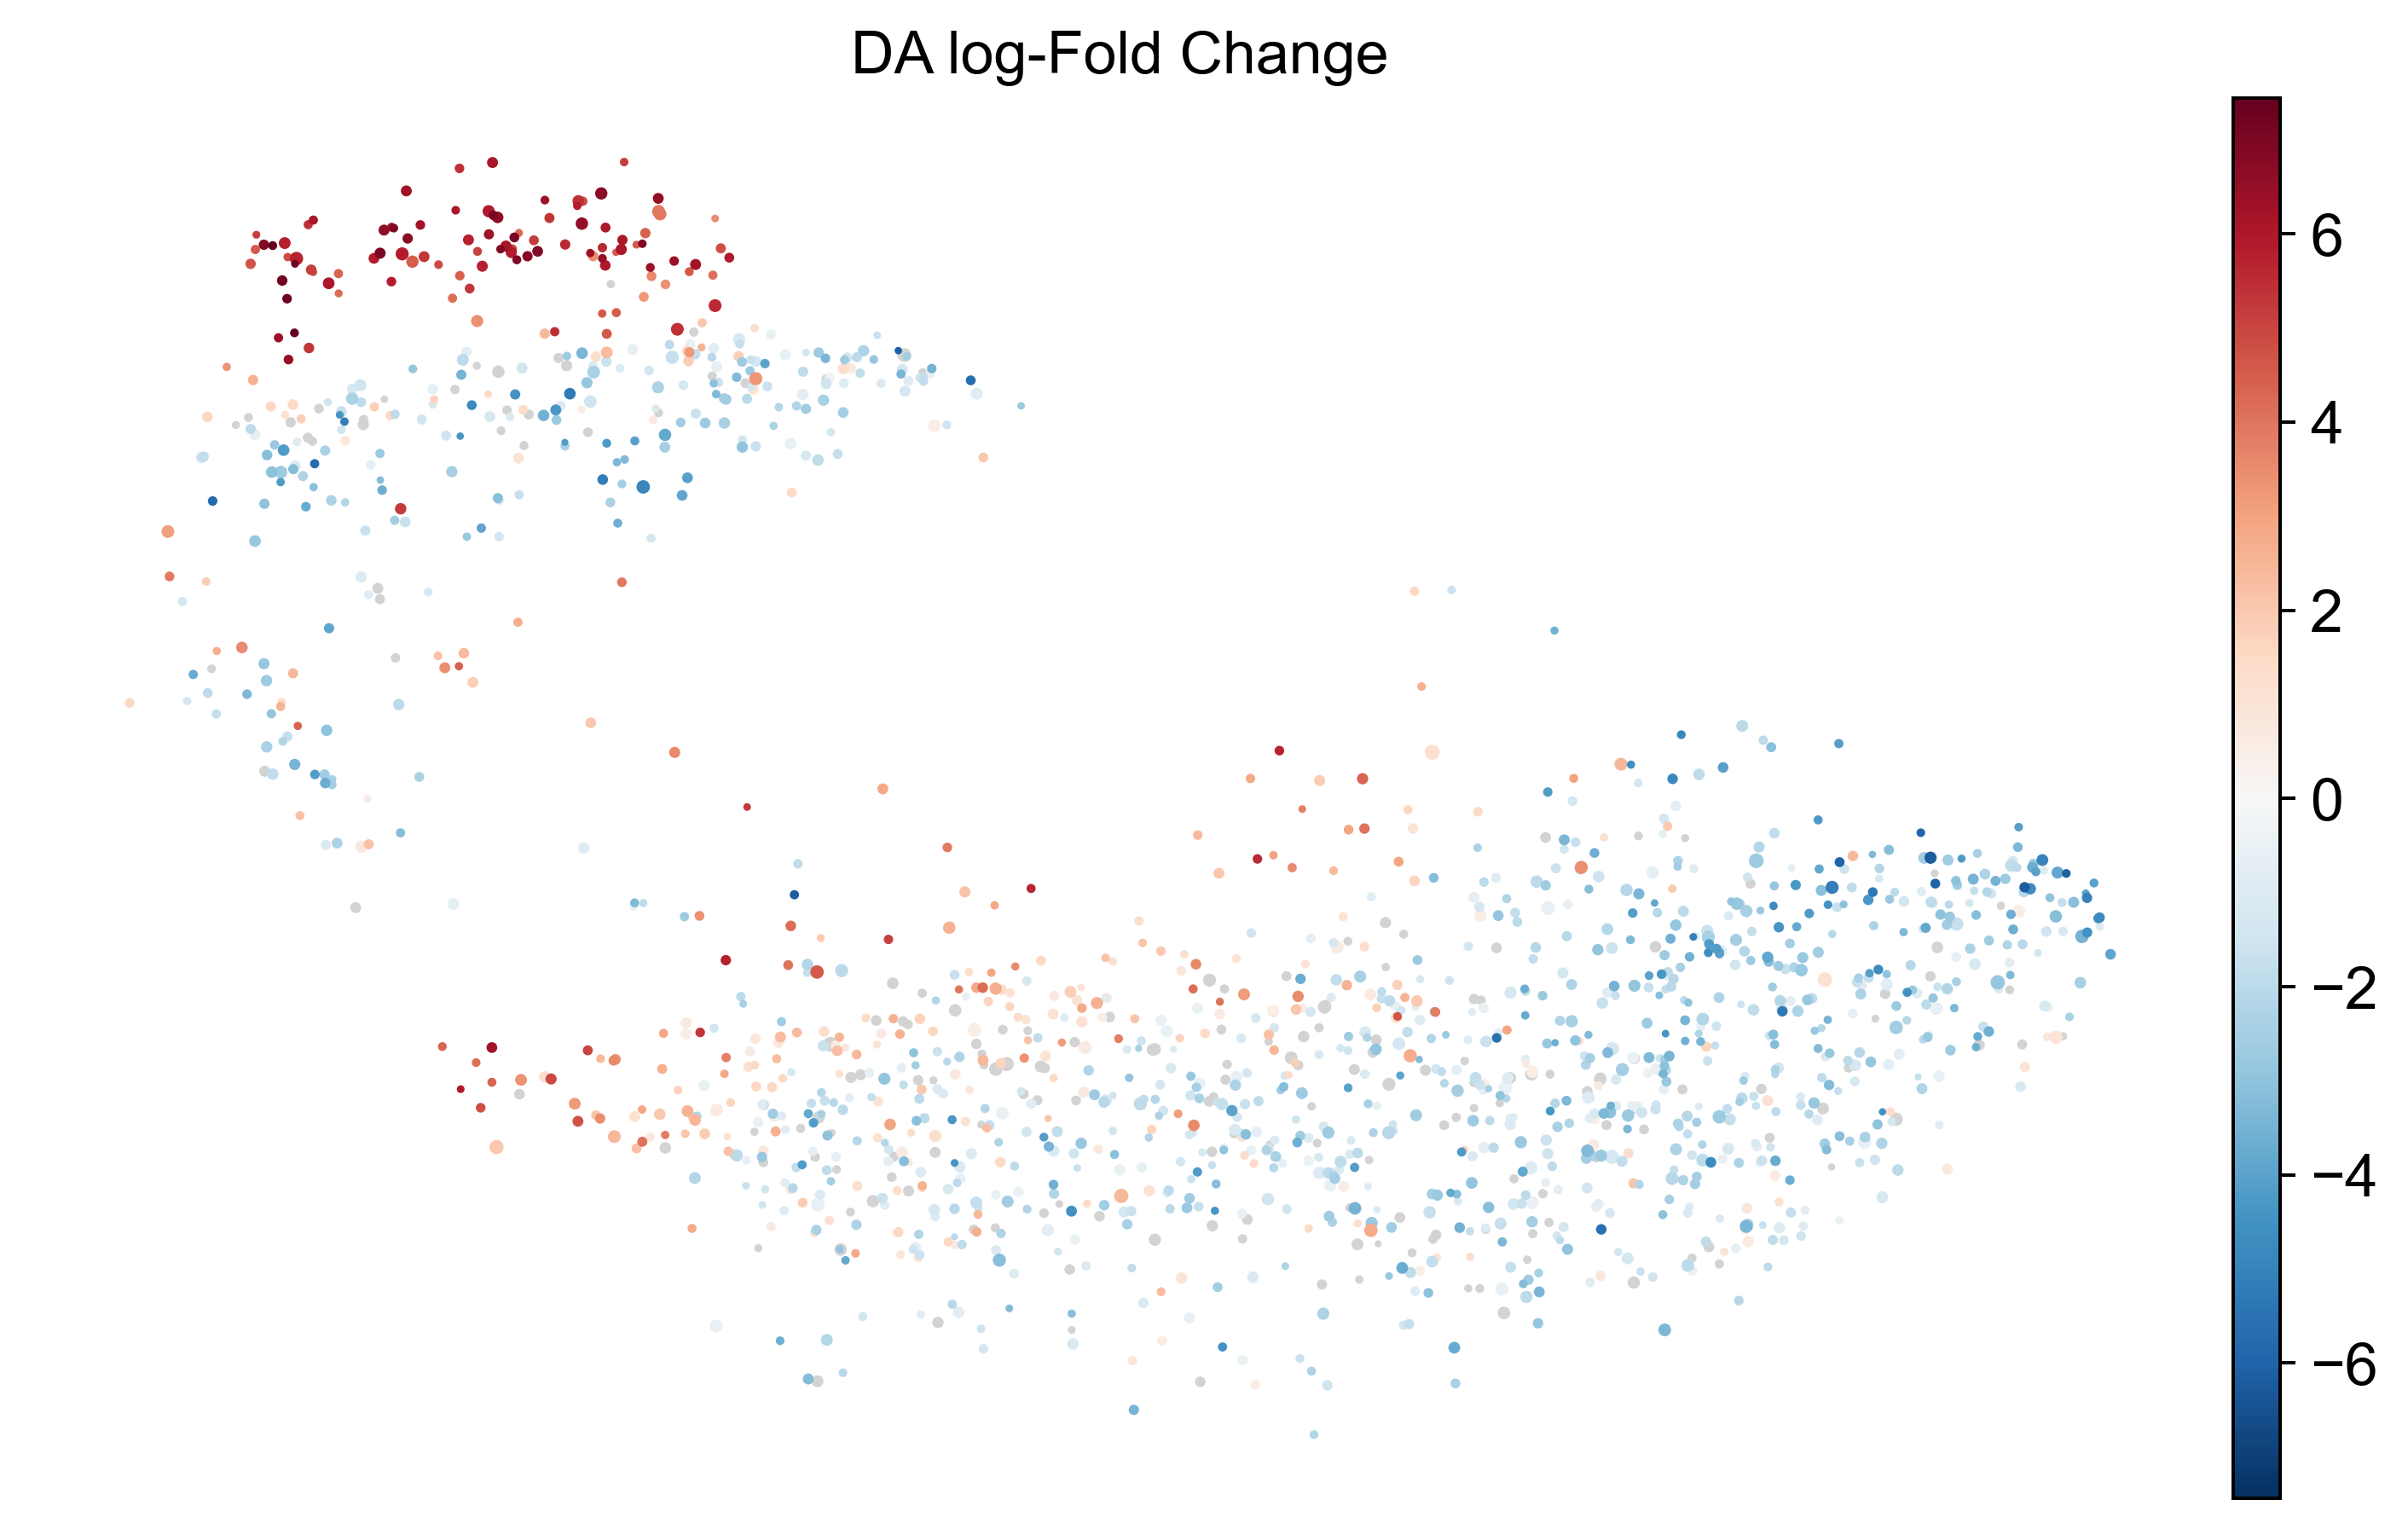

In [15]:
plt.rcParams["figure.figsize"] = [10,6]
milopy.utils.build_nhood_graph(adata)
milopy.plot.plot_nhood_graph(adata, alpha = 0.8, min_size = 0.2)

### Visualise results by cell type

In [16]:
milopy.utils.annotate_nhoods(adata, anno_col = 'cell_states')

Text(0.5, 0, 'cellstates fraction')

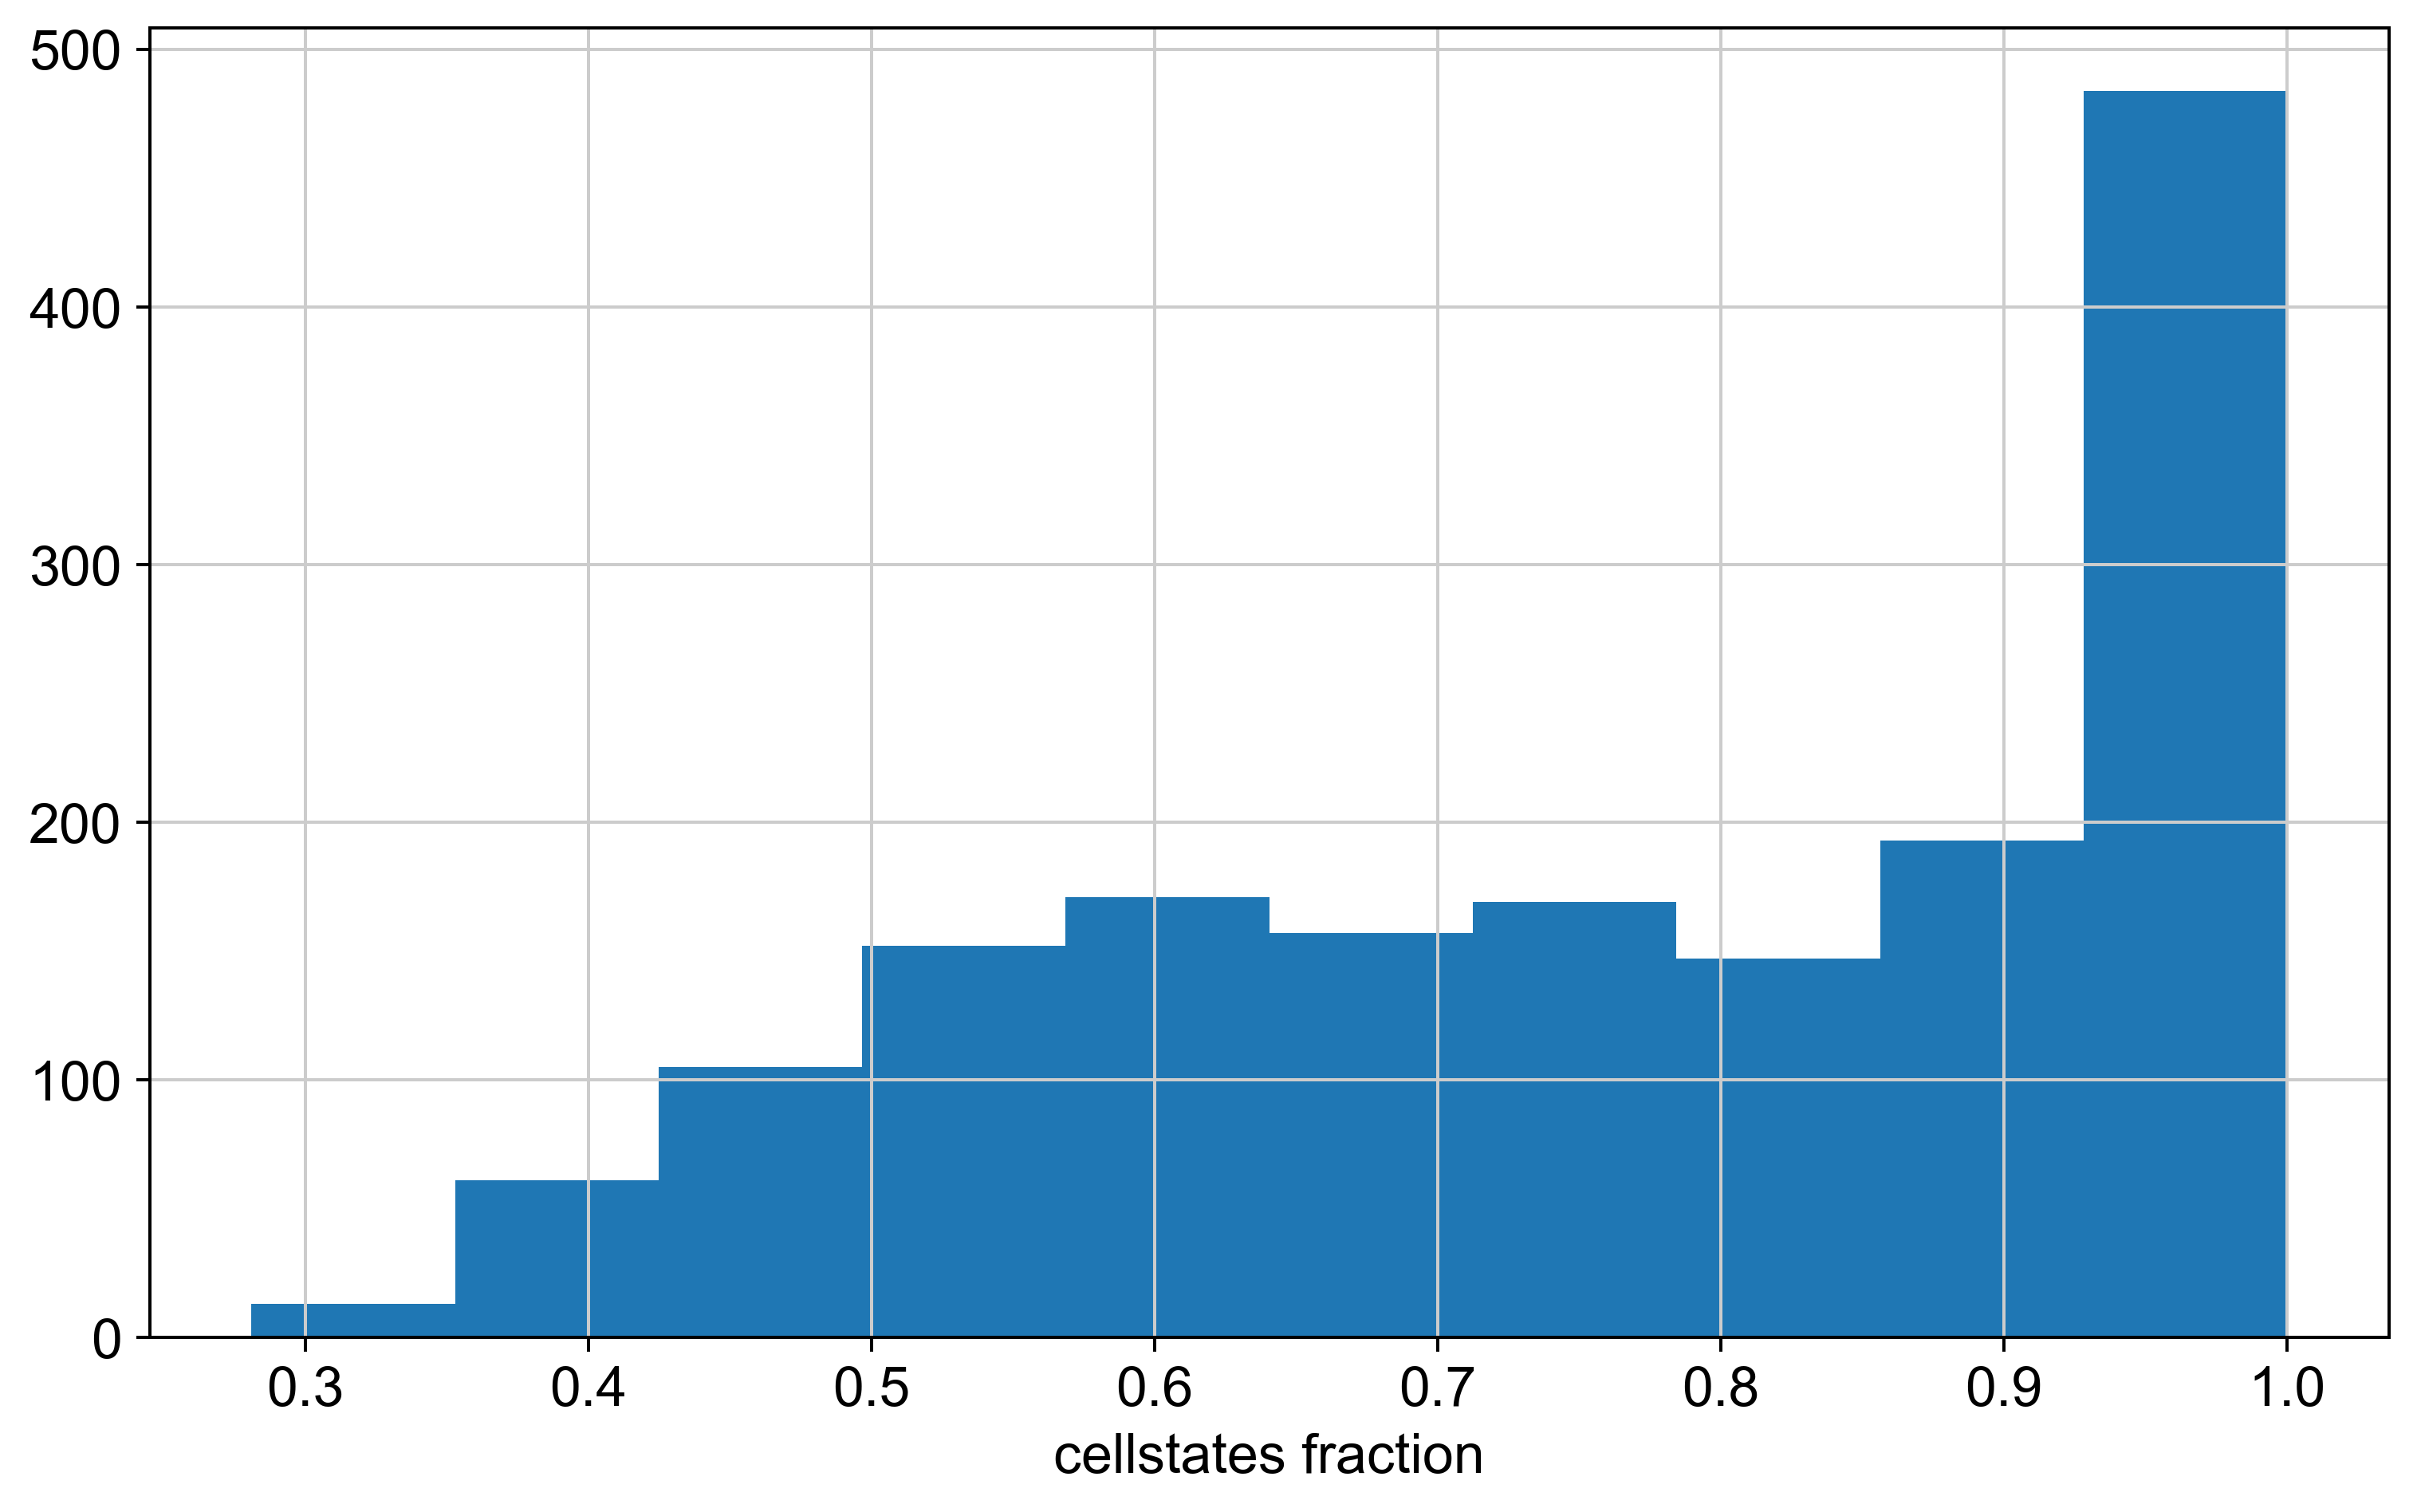

In [17]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"])
plt.xlabel("cellstates fraction")

In [18]:
nhood_annotation = adata.uns['nhood_adata'].obs['nhood_annotation']
nhood_annotation = nhood_annotation.cat.add_categories(['Ambiguous'])
adata.uns['nhood_adata'].obs['nhood_annotation'] = nhood_annotation

adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Ambiguous"


/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/sea

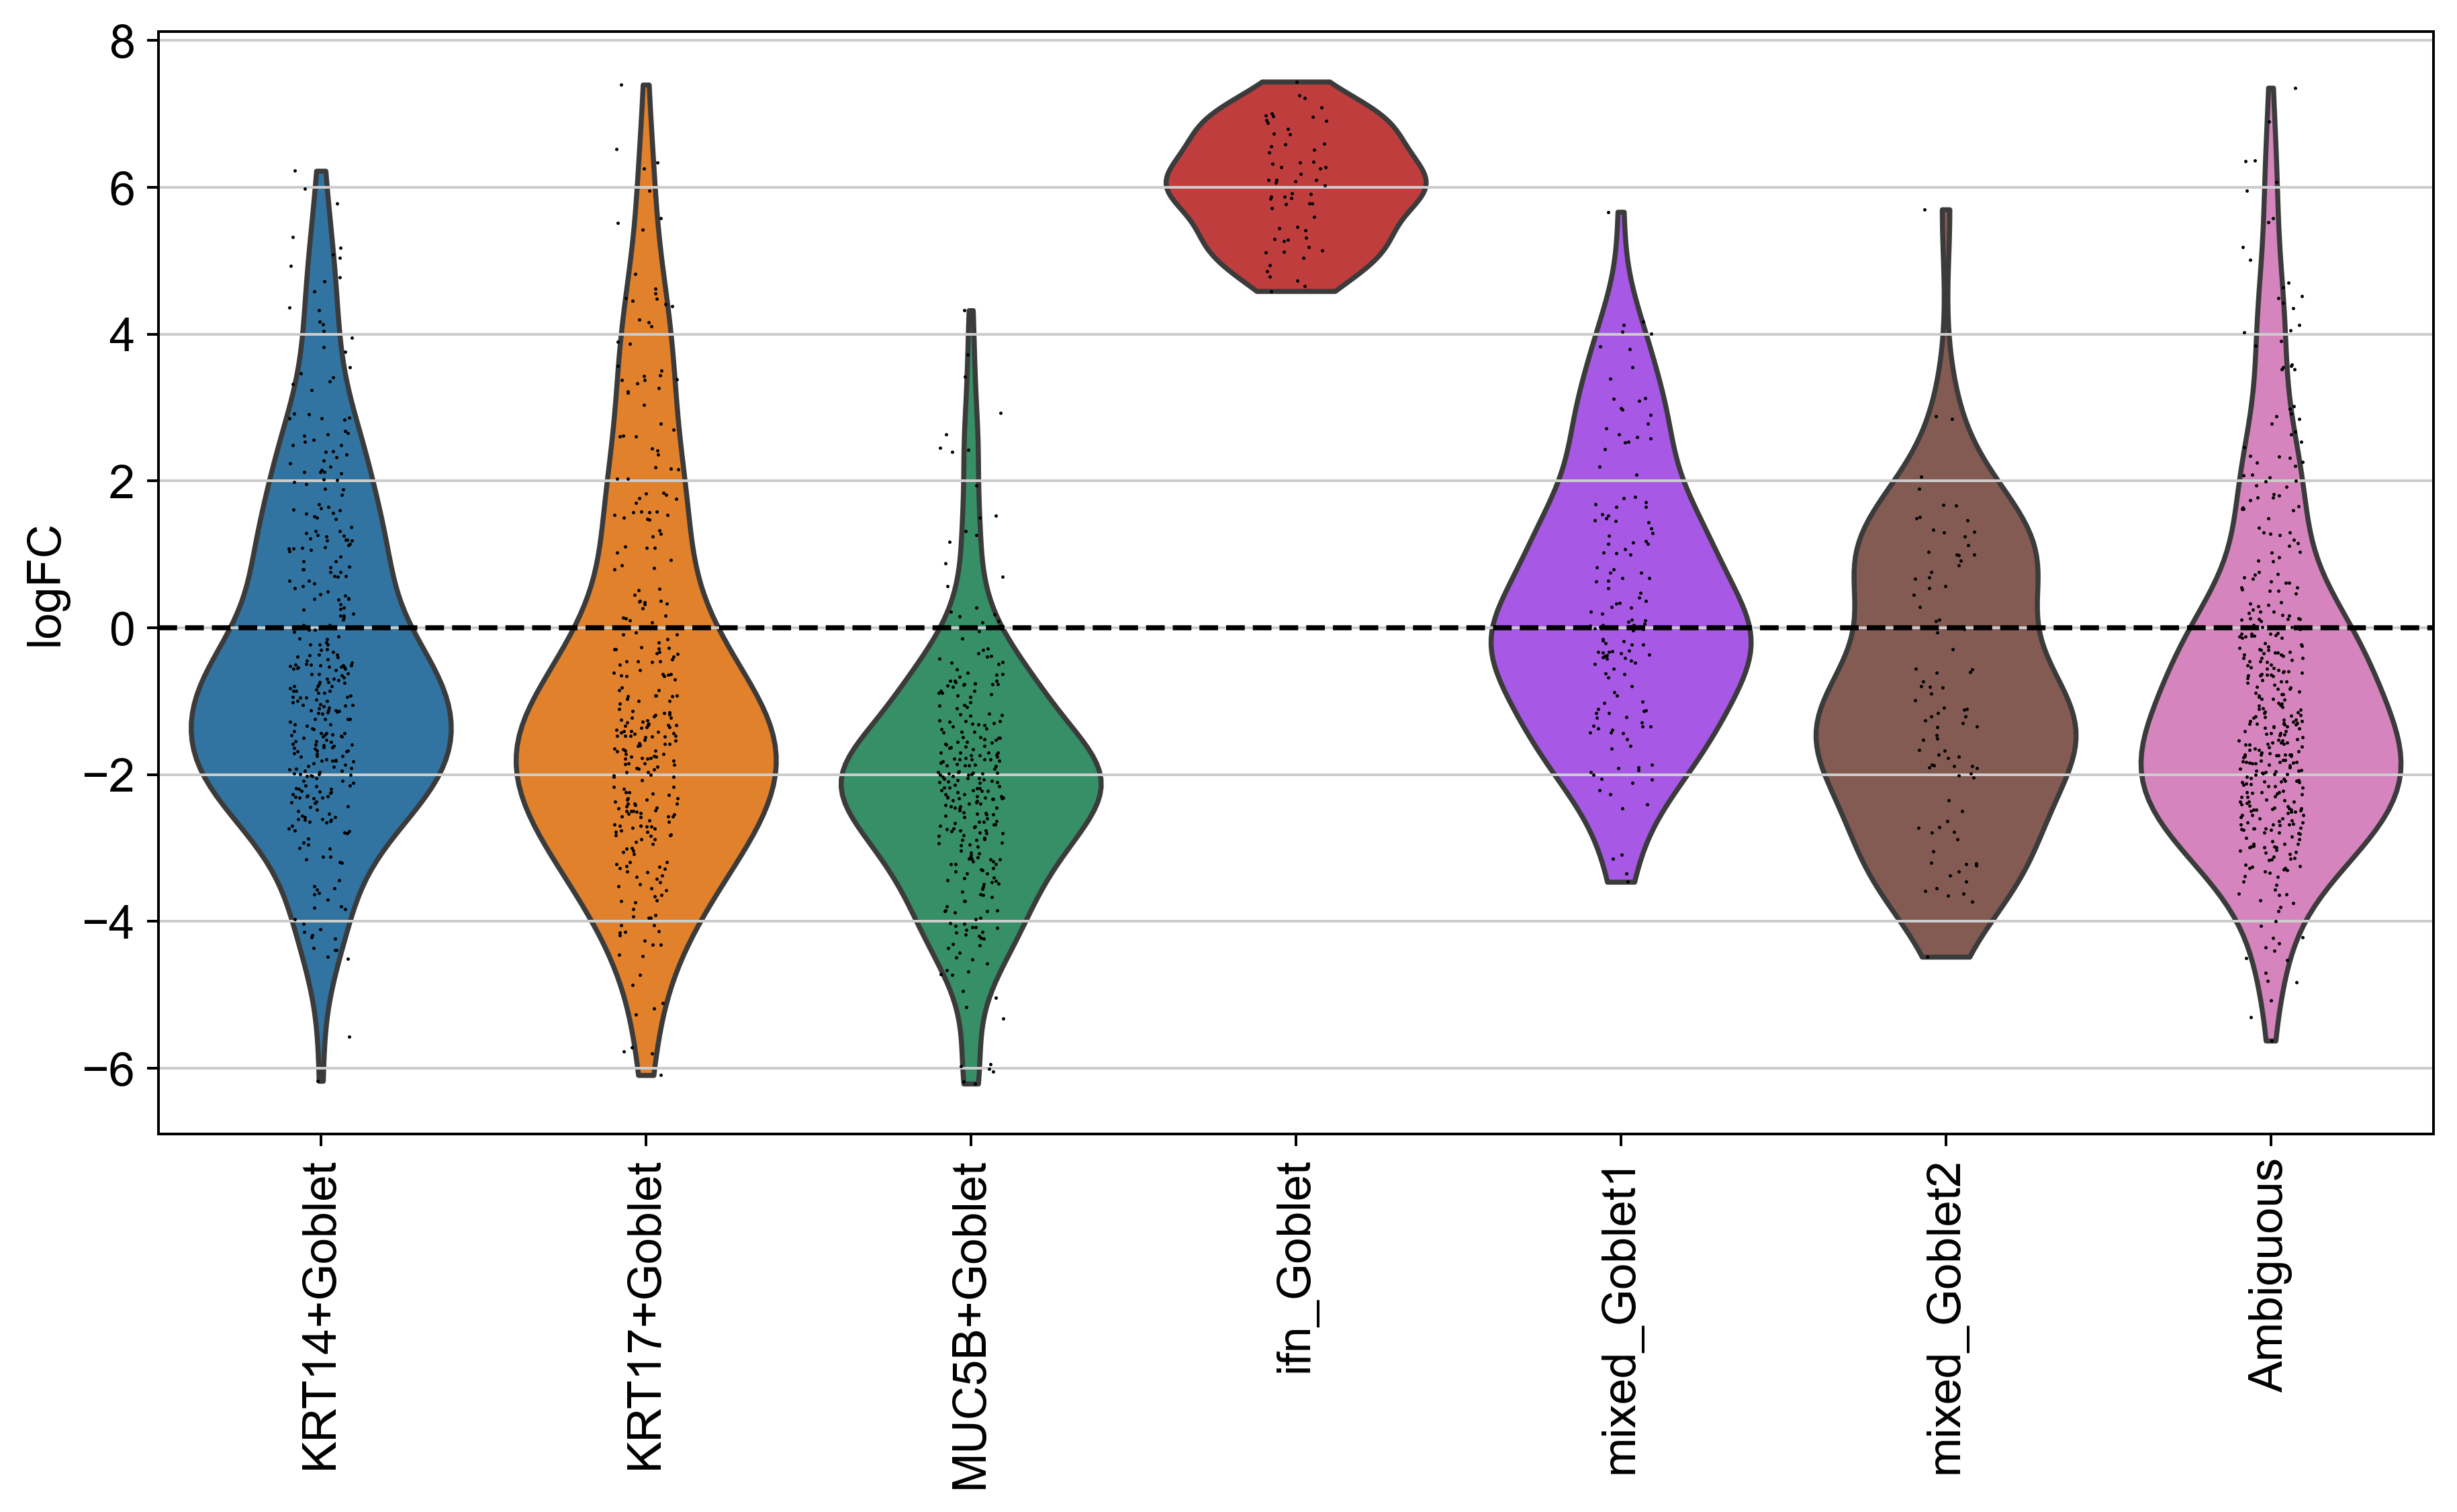

In [19]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby = "nhood_annotation", rotation = 90, show = False);
plt.axhline(y = 0, color = 'black', linestyle = '--');
plt.show()